In [ ]:
%pip install yfinance
%pip install finta
%pip install matplotlib
from finta import TA
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plot

In [2]:
# Allows for all rows to be seen, if you want a limit set it to some number.
pd.options.display.max_rows = None

In [ ]:
# Function with a 'folder' and 'years' argument. Purpose is to download and save historic price data for each ticker as .csv and also in a dictionary.
def download_stock_price_data_and_save_to_dict(folder='', years=5):

  # 'tickers' is a pandas DataFrame object. 'pd.read_csv' function reads csv file from this website which contains all of the stock ticker symbols under it's "ACT Symbol" column.
  tickers = pd.read_csv('https://pkgstore.datahub.io/core/nyse-other-listings/nyse-listed_csv/data/3c88fab8ec158c3cd55145243fe5fcdf/nyse-listed_csv.csv')
  # 'symbols' is an array of symbols we made by taking all the unique symbols from the tickers .csv
  symbols = tickers['ACT Symbol'].unique()
  # empty dictionary to store all stock price DataFrames.
  price_data_dict = {}

  # loop where we go through each symbol 's' in the symbols list (first 20), and then do some things.
  for s in symbols[0:20]:
    try:

      # creates the DataFrame 'price_data_df' from the downloaded yf price data over the last years. auto_adjust accounts for stock splits and such. Takes in each stock symbol 's' one at at time.
      price_data_df = yf.download([s], auto_adjust=True, period=f'{str(years)}y')

      # If the length of the dataframe is over 100, then go ahead and do the iteration.
      if len(price_data_df) > 100:
        # make the columns lowercase, rename the index to 'datetime', and adds the 'price_data_df' to the 'price_data_dict' with the key being the current symbol 's'
        price_data_df.columns = price_data_df.columns.str.lower()
        price_data_df.index = price_data_df.index.rename('datetime')
        # Incase you want/need to download the .csv files:
        #price_data_df.to_csv(f'{folder}{s}.csv')
        price_data_dict[s] = price_data_df

    # error catch
    except Exception as e:
      print(f'error with {s}')
      print(repr(e))
      continue
  
  # Allows for the 'price_data_dict' dictionary object to be accessed elsewhere in the code as a variable or input in another function.   
  return price_data_dict
  
# Download and saves price data to our price data dictionary.
price_data_dict = download_stock_price_data_and_save_to_dict()

In [4]:
def create_trade_entries_dict(price_data_dict):
    trade_entries_dict = {}

    # Iterates through the key:value pairs in the 'price_data_dict'
    for symbol, price_data_df in price_data_dict.items():
        # Copy input data frame so it doesn't modify it.
        price_data_df = price_data_df.copy()
        
        # Adding various columns to the original 'df'.
        price_data_df['EMA200'] = TA.EMA(price_data_df, period=200)
        price_data_df['EMA50'] = TA.EMA(price_data_df, period=50)
        price_data_df['ATR'] = TA.ATR(price_data_df)
        # entry is lazily done, it's just the opening price of the next row
        price_data_df['entry'] = price_data_df.shift(-1).open
        price_data_df['target'] = 0.0
        price_data_df['stop'] = 0.0
        price_data_df['risk:reward'] = 0.0
        price_data_df['target_pct'] = 0.0
        price_data_df['stop_pct'] = 0.0
        price_data_df['target_profit'] = 150
        price_data_df['position_size'] = 0.0

        # Conditions for long entry based on technical analysis indicators.
        c1 = price_data_df.close > price_data_df.EMA200
        c2 = (price_data_df.low < price_data_df.EMA50) & (price_data_df.close > price_data_df.EMA50) & (price_data_df.open > price_data_df.EMA50)
        # Boolean series that specifies the rows where the conditions are both met/true.
        long_entry_condition = (c1) & (c2)

        # Accesses and modifies all column row values in 'price_data_df' where long_entry_condition is true, and modifies the 2nd input '' column in those rows to what is specified.
        price_data_df.loc[long_entry_condition, 'target'] = price_data_df.entry + (1.5*price_data_df.ATR)
        price_data_df.loc[long_entry_condition, 'stop'] = price_data_df.entry - price_data_df.ATR
        price_data_df.loc[long_entry_condition, 'risk:reward'] = (price_data_df.target - price_data_df.entry) / (price_data_df.entry - price_data_df.stop)
        price_data_df.loc[long_entry_condition, 'target_pct'] = (price_data_df.target - price_data_df.entry) / (price_data_df.entry)
        price_data_df.loc[long_entry_condition, 'stop_pct'] = -(price_data_df.entry - price_data_df.stop) / (price_data_df.entry)
        price_data_df.loc[long_entry_condition, 'position_size'] = price_data_df.target_profit / price_data_df.target_pct

        # Selects the subset of rows where the price data in DataFrame 'price_data_df' satisfy the long entry condition, and then creates a copy of the modified DataFrame denoted 'entries'.
        entries_df = price_data_df.loc[long_entry_condition][['entry', 'target', 'stop', 'risk:reward', 'target_pct', 'stop_pct', 'target_profit', 'position_size']].copy()

        # Add the entry Data Frame to the dictionary with the corresponding stock symbol
        trade_entries_dict[symbol] = entries_df

    return trade_entries_dict

# Create the 'trade_entries_dict
trade_entries_dict = create_trade_entries_dict(price_data_dict)

In [ ]:
price_data_dict

In [ ]:
trade_entries_dict

In [7]:
# merges the price data and trade entries dictionaries. It's shorthand for creating a new dictionary from existing ones.
# for each 'key' in price_data_dict, it makes new key-value pair in the new dict. Rows are aligned based on their common index.
price_and_trades_dict = {key: pd.concat([price_data_dict[key], trade_entries_dict[key]], axis=1) for key in price_data_dict}

In [ ]:
price_and_trades_dict

In [9]:
# Function with purpose to create new dictionary which houses the trade results, with an input of the price_and_trades_dict dictionary.
def create_trade_results_dict(price_and_trades_dict):
    trade_results_dict = {}
    # Loop over items (view object key:value pairs) in 'price_and_trades_dict', going through each tuple one by one, where the key is 'symbol' and the value are the data frames 'trades_df' 
    for symbol, trades_df in price_and_trades_dict.items():
        # Initiating empty list and setting the trade number, which will be the index of our new data frames, to 1.
        trade_results = []
        trade_num = 1
        # Iterate rows in the data frame, yielding pairs of index and row data as a series. 'idx' is index which is the row label, and 'row' represents data in the current row as a series.
        for idx, row in trades_df.iterrows():
            # Check if the value of 'target' column in current row is > 0. (We are checking if a valid trade has taken place by making sure 'target' is not NaN basically)
            if row['target'] > 0:
                # Saves the index of the next row to 'entry_idx' variable. This accounts for the proper 'entry_date' being the next trading days open after a trade is triggered.
                entry_idx = trades_df.index.get_loc(idx) + 1
                # Check if the saved index is less than the length of the data frame. Thie ensures that the next row exists within the DataFrame, preventing errors.
                if entry_idx < len(trades_df):
                    # Sets the entry_date to the index of the entry.
                    entry_date = trades_df.index[entry_idx]
                    # Finds the exit row by starting at the 'entry_date' and onward due to the empty value after the ':'. Then it applies the lambda function to each row to check and see when the 'target' or 'stop' value from the original row is crossed by a future 'high' or 'low' value. 'idxmax()' returns index of the first true value since true is considered greater than false. So the result of this is the index of the exit row is assigned to 'exit_row_idx'.
                    exit_row_idx = trades_df.loc[entry_date:].apply(lambda x: x['high'] >= row['target'] or x['low'] <= row['stop'], axis=1).idxmax()
                    # exit_price is target or stop depending on which is hit.
                    exit_price = row['target'] if trades_df.loc[exit_row_idx, 'high'] >= row['target'] else row['stop']
                    # exit_date is the index of the exit row.
                    exit_date = exit_row_idx
                    # Simple calculations
                    days_in_trade = (exit_date - entry_date).days
                    win_loss = 1 if exit_price == row['target'] else -1
                    p_l = 150 if win_loss == 1 else -100
                    # Appends the desired row values to the initially empty 'trade_results' list, and then ticks forward the 'trade_num' to start the process again.
                    trade_results.append([trade_num, entry_date, row['entry'], row['target'], row['stop'], exit_price, exit_date, days_in_trade, row['position_size'], win_loss, p_l])
                    trade_num += 1
        # Creates a data frame which houses the list of values from the 'trade_results' list, with the following strings as the column headers.
        trade_results_df = pd.DataFrame(trade_results, columns=['trade_num', 'entry_date', 'entry', 'target', 'stop', 'exit_price', 'exit_date', 'days_in_trade', 'position_size', 'win_loss', 'p_l'])
        # Sets index of the data frame to the trade number
        trade_results_df.set_index('trade_num', inplace=True)
        # Adds the DataFrame to the dictionary with the current symbol as the key, storing the trade results for each symbol in the dictionary.
        trade_results_dict[symbol] = trade_results_df
    # Returns entire dictionary with all the symbols after the loop is finished, so we can use it elsewhere in the code.
    return trade_results_dict
# Produces the 'trade_results_dict' based on the 'price_and_trades_dict' data, storing the entire dictionary to the 'trade_results_dict' variable.
trade_results_dict = create_trade_results_dict(price_and_trades_dict)

In [10]:
trade_results_dict

{'A':           entry_date       entry      target        stop  exit_price  \
 trade_num                                                              
 1         2018-05-09   64.922352   66.764064   63.694545   66.764064   
 2         2018-06-18   63.091658   64.760966   61.978786   61.978786   
 3         2018-08-17   63.244025   65.168829   61.960823   65.168829   
 4         2018-11-08   65.807315   68.568930   63.966239   63.966239   
 5         2018-11-21   65.487934   68.233991   63.657229   68.233991   
 6         2019-01-09   66.173819   69.498250   63.957531   69.498250   
 7         2019-06-21   71.112151   72.965377   69.876666   72.965377   
 8         2019-06-25   71.160789   72.966096   69.957250   72.966096   
 9         2019-06-26   70.626022   72.441746   69.415540   72.441746   
 10        2019-06-28   71.228828   73.033091   70.025987   73.033091   
 11        2019-10-21   73.121157   75.451183   71.567806   75.451183   
 12        2019-10-28   73.912134   75.970134 

In [11]:
# Initialize variables
num_trades = 0
num_win_trades = 0
num_lost_trades = 0
sum_trades = 0
max_days = float('-inf')
min_days = float('inf')
total_days = 0
total_pos_size = 0
max_pos_size = float('-inf')
min_pos_size = float('inf')
net_p_l = 0

# Loop through the trade_results_dict
for df in trade_results_dict.values():
    num_trades += len(df)
    num_win_trades += len(df[df['win_loss'] == 1])
    num_lost_trades += len(df[df['win_loss'] == -1])
    sum_trades += df['win_loss'].sum()
    max_days = max(max_days, df['days_in_trade'].max())
    min_days = min(min_days, df['days_in_trade'].min())
    total_days += df['days_in_trade'].sum()
    total_pos_size += df['position_size'].sum()
    max_pos_size = max(max_pos_size, df['position_size'].max())
    min_pos_size = min(min_pos_size, df['position_size'].min())
    net_p_l += df['p_l'].sum()

# Calculate averages
avg_days = total_days / num_trades
avg_pos_size = total_pos_size / num_trades

# Create a DataFrame with the results
results_df = pd.DataFrame({
    "trades": [num_trades],
    "winning_trades": [num_win_trades],
    "losing_trades": [num_lost_trades],
    "wins_vs_losses": [sum_trades],
    "max_days": [max_days],
    "min_days": [min_days],
    "avg_days": [avg_days],
    "avg_pos_size": [avg_pos_size],
    "max_pos_size": [max_pos_size],
    "min_pos_size": [min_pos_size],
    "net_p_l": [net_p_l],
})

# Remove the index by converting the DataFrame to a dictionary and back to a DataFrame
results_df = pd.DataFrame(results_df.to_dict(orient='records'))

print(results_df.to_string(index=False))

 trades  winning_trades  losing_trades  wins_vs_losses  max_days  min_days  avg_days  avg_pos_size  max_pos_size  min_pos_size  net_p_l
    529             219            310             -91        35         0   5.73724   5014.544541  57224.374853   1138.103404     1850


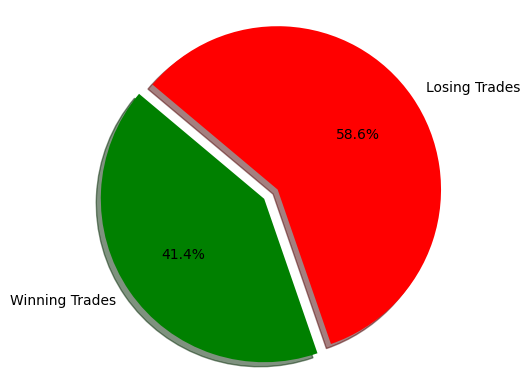

In [12]:

# Setting up and saving data neccessary to plot a pie chart
winning_trades = results_df['winning_trades'][0]
losing_trades = results_df['losing_trades'][0]
# Data to plot
labels = ['Winning Trades', 'Losing Trades']
sizes = [winning_trades, losing_trades]
colors = ['green', 'red']
explode = (0.1, 0)  # "explode" the Winning Trades slice

# Plot the pie chart
plot.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plot.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Show the pie chart
plot.show()
# plot.savefig('pie_chart.png')  # save chart as image file if you want